# Init

In [1]:
from pyfiles import (
    complex as cplx,
    grid as grid,
    utils as utils,
    examples as ex,
    input as inp,
    plot as ourplot
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from typing import *
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import mars

def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4
    print(f'Wrote {filename}')

def plotline(ax, p, q, *args, **kwargs):
    ax.plot([p[0], q[0]], [p[1], q[1]], [p[2], q[2]], *args, **kwargs)


# input

In [2]:
# example = ex.theta

# our_complex = inp.read_obj(example.filename)
# gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

# rs_complex = mars.read_from_obj(example.filename)

# list_of_swaps = []
# '''A list of swaps of the form `(old-cell, new-cell, [swaps])`'''

# rs_states = {}
# '''States for each point.  Used to live in the python Grid3'''

# n_edges = gridd.number_of_grid_edges()
# visit_count = 0
# def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
#   global visit_count
#   visit_count += 1
#   perf = visit_count / n_edges * 100
#   print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
#   if old_cell is None:
#     center_point = gridd.coordinate(new_cell)
#     with utils.Timed('rs reduce'):
#       rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
#   else:
#     new_point = gridd.coordinate(new_cell)
#     with utils.Timed('rs reduce_vine'):
#       rs_old_state = rs_states[old_cell]
#       (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
#       list_of_swaps.append((old_cell, new_cell, swaps))
#       rs_states[new_cell] = rs_new_state

# with utils.Timed('flood_fill_visit'):
#   gridd.flood_fill_visit((0, 0, 0), visit)
# utils.Timed.report()



In [3]:
example = ex.rect_test2
rs_complex = mars.read_from_obj(example.filename)
our_complex = inp.read_obj(example.filename)
rgrid = mars.Grid.around_complex(rs_complex, example.grid_size, example.grid_buffer)
with utils.Timed('all rust'):
  res = rgrid.run_state(1000, rs_complex, True)
utils.Timed.report()

Reduce around 12 states from scratch ...
pop grid volume 12936
pop grid volume 6776
pop grid volume 6468
pop grid volume 3696
pop grid volume 3388
pop grid volume 3528
pop grid volume 3234
pop grid volume 2016
pop grid volume 1848
pop grid volume 1848
pop grid volume 1694
pop grid volume 1848
pop grid volume 1848
pop grid volume 1694
pop grid volume 1694
pop grid volume 1152
pop grid volume 1008
pop grid volume 1056
pop grid volume 924
Reduce dim0 ... done
Reduce dim1 ... done
Reduce dim2 ... done
Invert V0 ... done
Invert V1 ... done
Invert V2 ... done
pop grid volume 1056
pop grid volume 924
Reduce dim0 ... done
Reduce dim1 ... done
Reduce dim2 ... done
Invert V0 ... done
Invert V1 ... done
Invert V2 ... done
pop grid volume 968
Reduce dim0 ... done
Reduce dim1 ... done
Reduce dim2 ... done
Invert V0 ... done
Invert V1 ... done
Invert V2 ... done
pop grid volume 847
Reduce dim0 ... done
Reduce dim1 ... done
Reduce dim2 ... done
Invert V0 ... done
Invert V1 ... done
Invert V2 ... done

Run vineyards in grids: 1.682823667s


# chop chop

Found 1216 faces
Wrote output/extruded_rect_2-GB0.1-GS0.1-MA0-peps1.obj
(21, 11, 7)


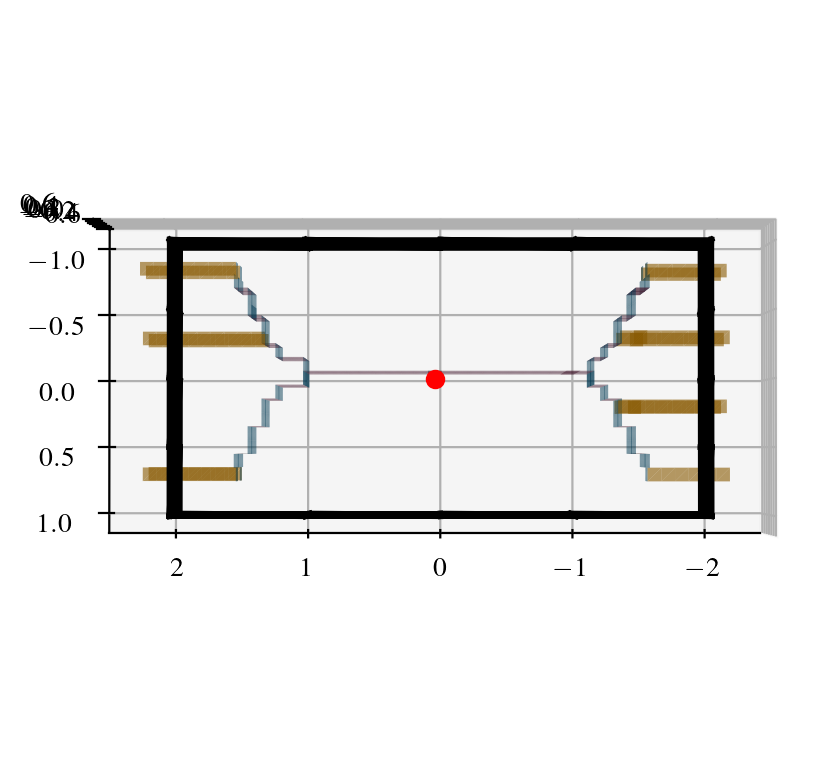

In [44]:
# CONTROL PARAMETERS
medaxdim = 0 # can say example.medial_axis when set

# euclidean prune: all dims
euclid_prune = True
prune_dist = 0.1

# coboundary: dim 0,2
cofaceprune = True

# faceprune: dim 1,2
faceprune = False

# persistence prune: dim 1
persprune = False
persistence_threshold = 0.01

###########################################

faces = []
rs_states, swaps = res
for (old_cell, new_cell, swaps) in swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]
  swaps = swaps.pyclone()

  # PRUNING
  # coboundary: mainly for dim 0,2
  if cofaceprune:
    swaps.prune_coboundary(rs_complex)
  if faceprune:
    swaps.prune_common_face(rs_complex)

  # persistence: mainly for dim 1
  if persprune:
    swaps.prune_persistence(rs_complex, state_old, state_new, persistence_threshold)

  # euclidean prune: for all dims
  # NOTE: dist prune is NOT grid size based, it is absolute dist
  # if example.prune_dist is not None:
  #   swaps.prune_euclidian(rs_complex, example.prune_dist**2)
  if euclid_prune:
    swaps.prune_euclidian(rs_complex, prune_dist**2)
  # END PRUNING

  # CHOOSE MEDIAL AXIS HERE (`example.medial_axis`):
  swaps = list(filter(lambda t: t.dim == medaxdim, swaps.v))

  if 0 < len(swaps):
    faces.append(
      list(map(np.array, 
      rgrid.dual_face(list(old_cell), list(new_cell))))
      )

print(f'Found {len(faces)} faces')
export_obj(example, our_complex, faces)
plot, ax = ourplot.plot_vineyard_results(
  our_complex,
  grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer),
  faces,
  CameraOpt(azim=90, elev=89),
  # only_edges=True,
  # complex_vertices=True,
  skip_grid=True,
  # skip_cube=True
)
cell = tuple(rgrid.closest_index_of([0, 0., 0]))
# cell = tuple(np.array(rgrid.shape) // 2)
print(cell)
state = rs_states[cell]
grid_pos = rgrid.coordinate(list(cell))
ax.plot([grid_pos[0]], [grid_pos[1]], [grid_pos[2]], 'ro')


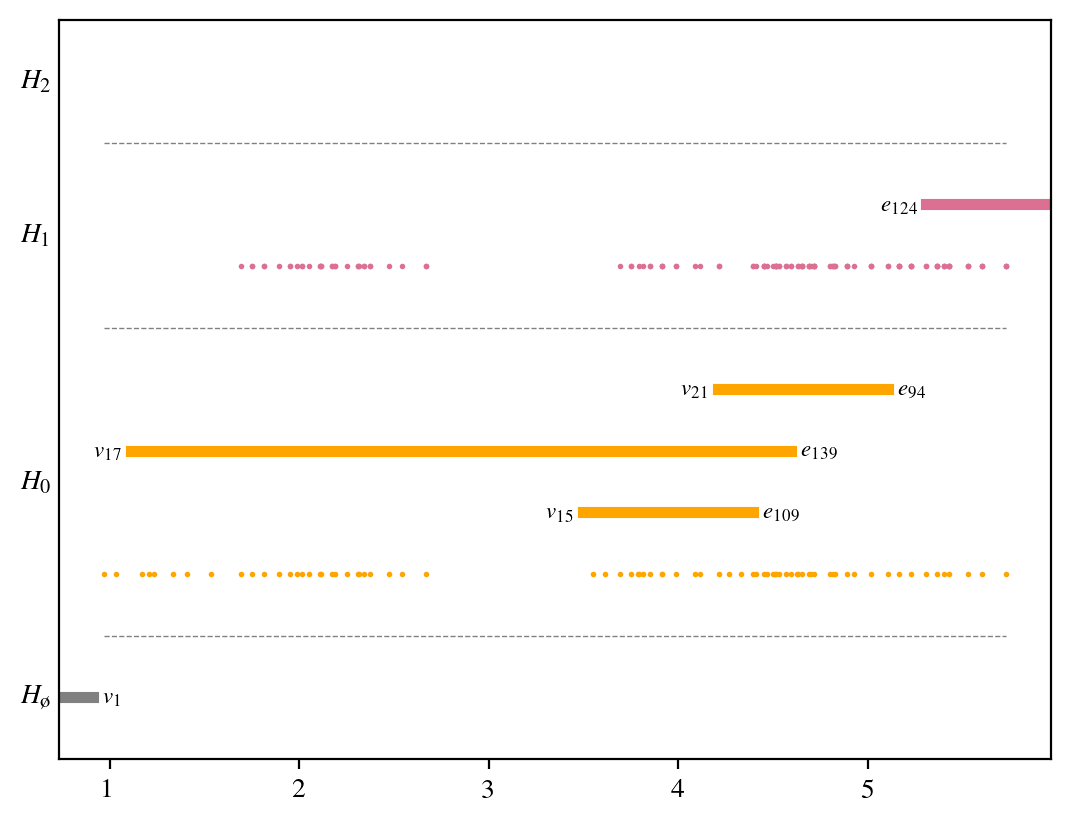

In [45]:
barcode = state.barcode(rs_complex, 0)
barcodes = {dim: state.barcode(rs_complex, dim) for dim in range(-1, 3)}
earliest_birth = min(
  t.birth[0] for dim in range(-1, 3) for t in barcodes[dim]  if t.birth is not None
)
latest_death = max(
  t.death[0] for dim in range(-1, 3) for t in barcodes[dim]  if t.death is not None
)
span = latest_death - earliest_birth

padding = 0.05
xmin = earliest_birth - span * padding
xmax = latest_death + span * padding

fig, ax = plt.subplots()
fig.set_dpi(200)
ax.set_xlim(xmin, xmax)
ax.set_yticks([])
matplotlib.rc("font", **{"family": "serif", "serif": ["Times"]})
matplotlib.rc("text", usetex=True)

dim2label = {-1: 'ø', 0: 'v', 1: 'e', 2: 't'}
dim2color = {
  -1: 'gray',
  0: 'orange',
  1: 'palevioletred',
  2: 'cornflowerblue'
}

label_padding = 0.05
y = 0
for dim in range(-1, 3):
  color = dim2color[dim]
  barcode = barcodes[dim]
  if 0 <= dim:
    ax.plot([earliest_birth, latest_death], [y, y], color='gray', linestyle='--', linewidth=0.5)
  first_y = y
  if 0 <= dim:
    y += 1
    pt_y = y
  y += 1
  for bar in barcode:

    if bar.birth is None:
      q = bar.death[0]
      ax.plot([xmin, q], [y,y], color=color, linewidth=4)
      ax.text(q + label_padding, y, f'${dim2label[dim + 1]}_{{{bar.death[1]}}}$', size='small', horizontalalignment='left', verticalalignment='center')
    elif bar.death is None:
      p = bar.birth[0]
      ax.plot([p, xmax], [y,y], color=color, linewidth=4)
      ax.text(p - label_padding, y, f'${dim2label[dim]}_{{{bar.birth[1]}}}$', size='small', horizontalalignment='right', verticalalignment='center')
    elif bar.birth[0] == bar.death[0]:
      p = bar.birth[0]
      ax.plot(p, pt_y, 'o', markersize=1, color=color)
      y -= 1
    else:
      p = bar.birth[0]
      q = bar.death[0]
      ax.plot([p, q], [y, y], color=color, linewidth=4)
      ax.text(p - label_padding, y, f'${dim2label[dim]}_{{{bar.birth[1]}}}$', size='small', horizontalalignment='right', verticalalignment='center')
      ax.text(q + label_padding, y, f'${dim2label[dim+1]}_{{{bar.death[1]}}}$', size='small', horizontalalignment='left', verticalalignment='center')
    y += 1
  ax.text(xmin -0.05, (first_y + y) / 2, f'$H_{{{dim if dim >= 0 else "ø"}}}$', horizontalalignment='right', verticalalignment='center')
ax.set_ylim(0, y);